In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np

import torch
import tqdm

from ray import tune

import stable_baselines


import autonomous_optimizer
import benchmark

First, open up a terminal window and run
```bash
$ tensorboard --logdir tb_logs
```

Then open up the tensorboard interface, usually at [http://localhost:6006](http://localhost:6006)



## Convex Quadratics

First, we will examine performance on convex quadratic objective functions. We generate 90 convex quadratics in two dimensions with eigenvalues uniformly distributed between 1 and 30 as the train set.

In [107]:
quadratic_dataset = [benchmark.convex_quadratic() for _ in range(90)]

Now we define the RL environment and our model.

In [108]:
quadratic_env = stable_baselines.common.vec_env.DummyVecEnv([
    lambda: autonomous_optimizer.Environment(quadratic_dataset, num_steps=40, history_len=25)
]*32)

quadratic_policy = stable_baselines.PPO2(
    stable_baselines.common.policies.MlpPolicy,
    quadratic_env,
    n_steps=2,
    verbose=0,
    tensorboard_log='tb_logs/quadratic'
)

Train the algorithm on 20 passes over the dataset

In [109]:
quadratic_policy.learn(total_timesteps=200 * quadratic_env[0].num_steps * len(quadratic_dataset))

We will be comparing the RL optimizer to several common convex optimization algorithms. We use Bayesian optimization to find good hyperparameters for this class of problems. And to make this a fair comparison, we will also run 20 passes over all problems in the dataset, just like the RL algorithm gets.

In [110]:
quadratic_tune = {
    "sgd": {"hyperparams": {"lr": 5e-2}},
    "momentum": {"hyperparams": {"lr": 5e-2, "momentum": 0.7}},
    "adam": {"hyperparams": {"lr": 5e-1}}
}

Now, let's compare their behavior on an example problem.

In [169]:
problem = benchmark.convex_quadratic()

model0 = problem["model0"]
obj_function = problem["obj_function"]
optimal_x = problem["optimal_x"]
optimal_value = problem["optimal_val"]
A = problem["A"]
b = problem["b"]
    
print(f'Objective function minimum: {optimal_value}')

Objective function minimum: -0.0021755460184067488


Run algos with our tuned hyperparams

In [170]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, quadratic_tune, quadratic_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

SGD optimality gap: 0.0
Momentum optimality gap: 1.3472279533743858e-05
Adam optimality gap: 0.018311838386580348
LBFGS optimality gap: -2.3283064365386963e-10
Autonomous Optimizer optimality gap: 0.026127126766368747


Distance from optimal vs iteration

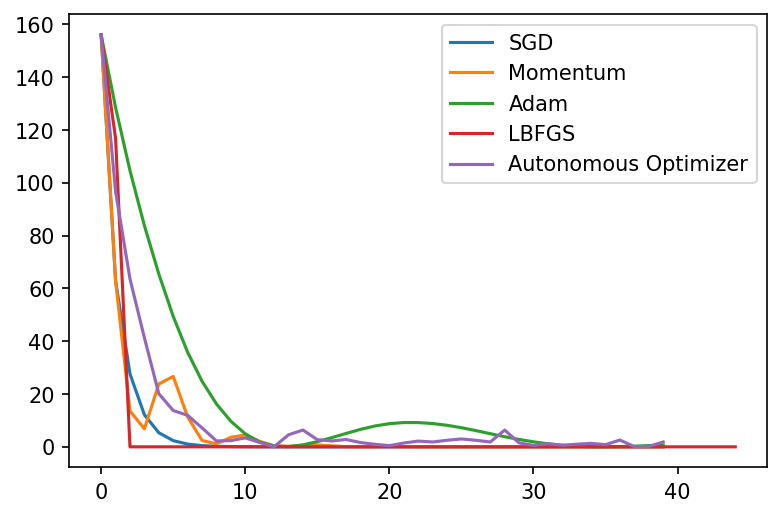

In [172]:
plt.figure(figsize=(6, 4), dpi=150)

plt.plot(sgd_vals - optimal_value, label='SGD')
plt.plot(momentum_vals - optimal_value, label='Momentum')
plt.plot(adam_vals - optimal_value, label='Adam')
plt.plot(lbfgs_vals - optimal_value, label='LBFGS')
plt.plot(ao_vals - optimal_value, label='Autonomous Optimizer')

plt.legend()
plt.show()

Plotting trajectories on a 2-D slice of the parameter space

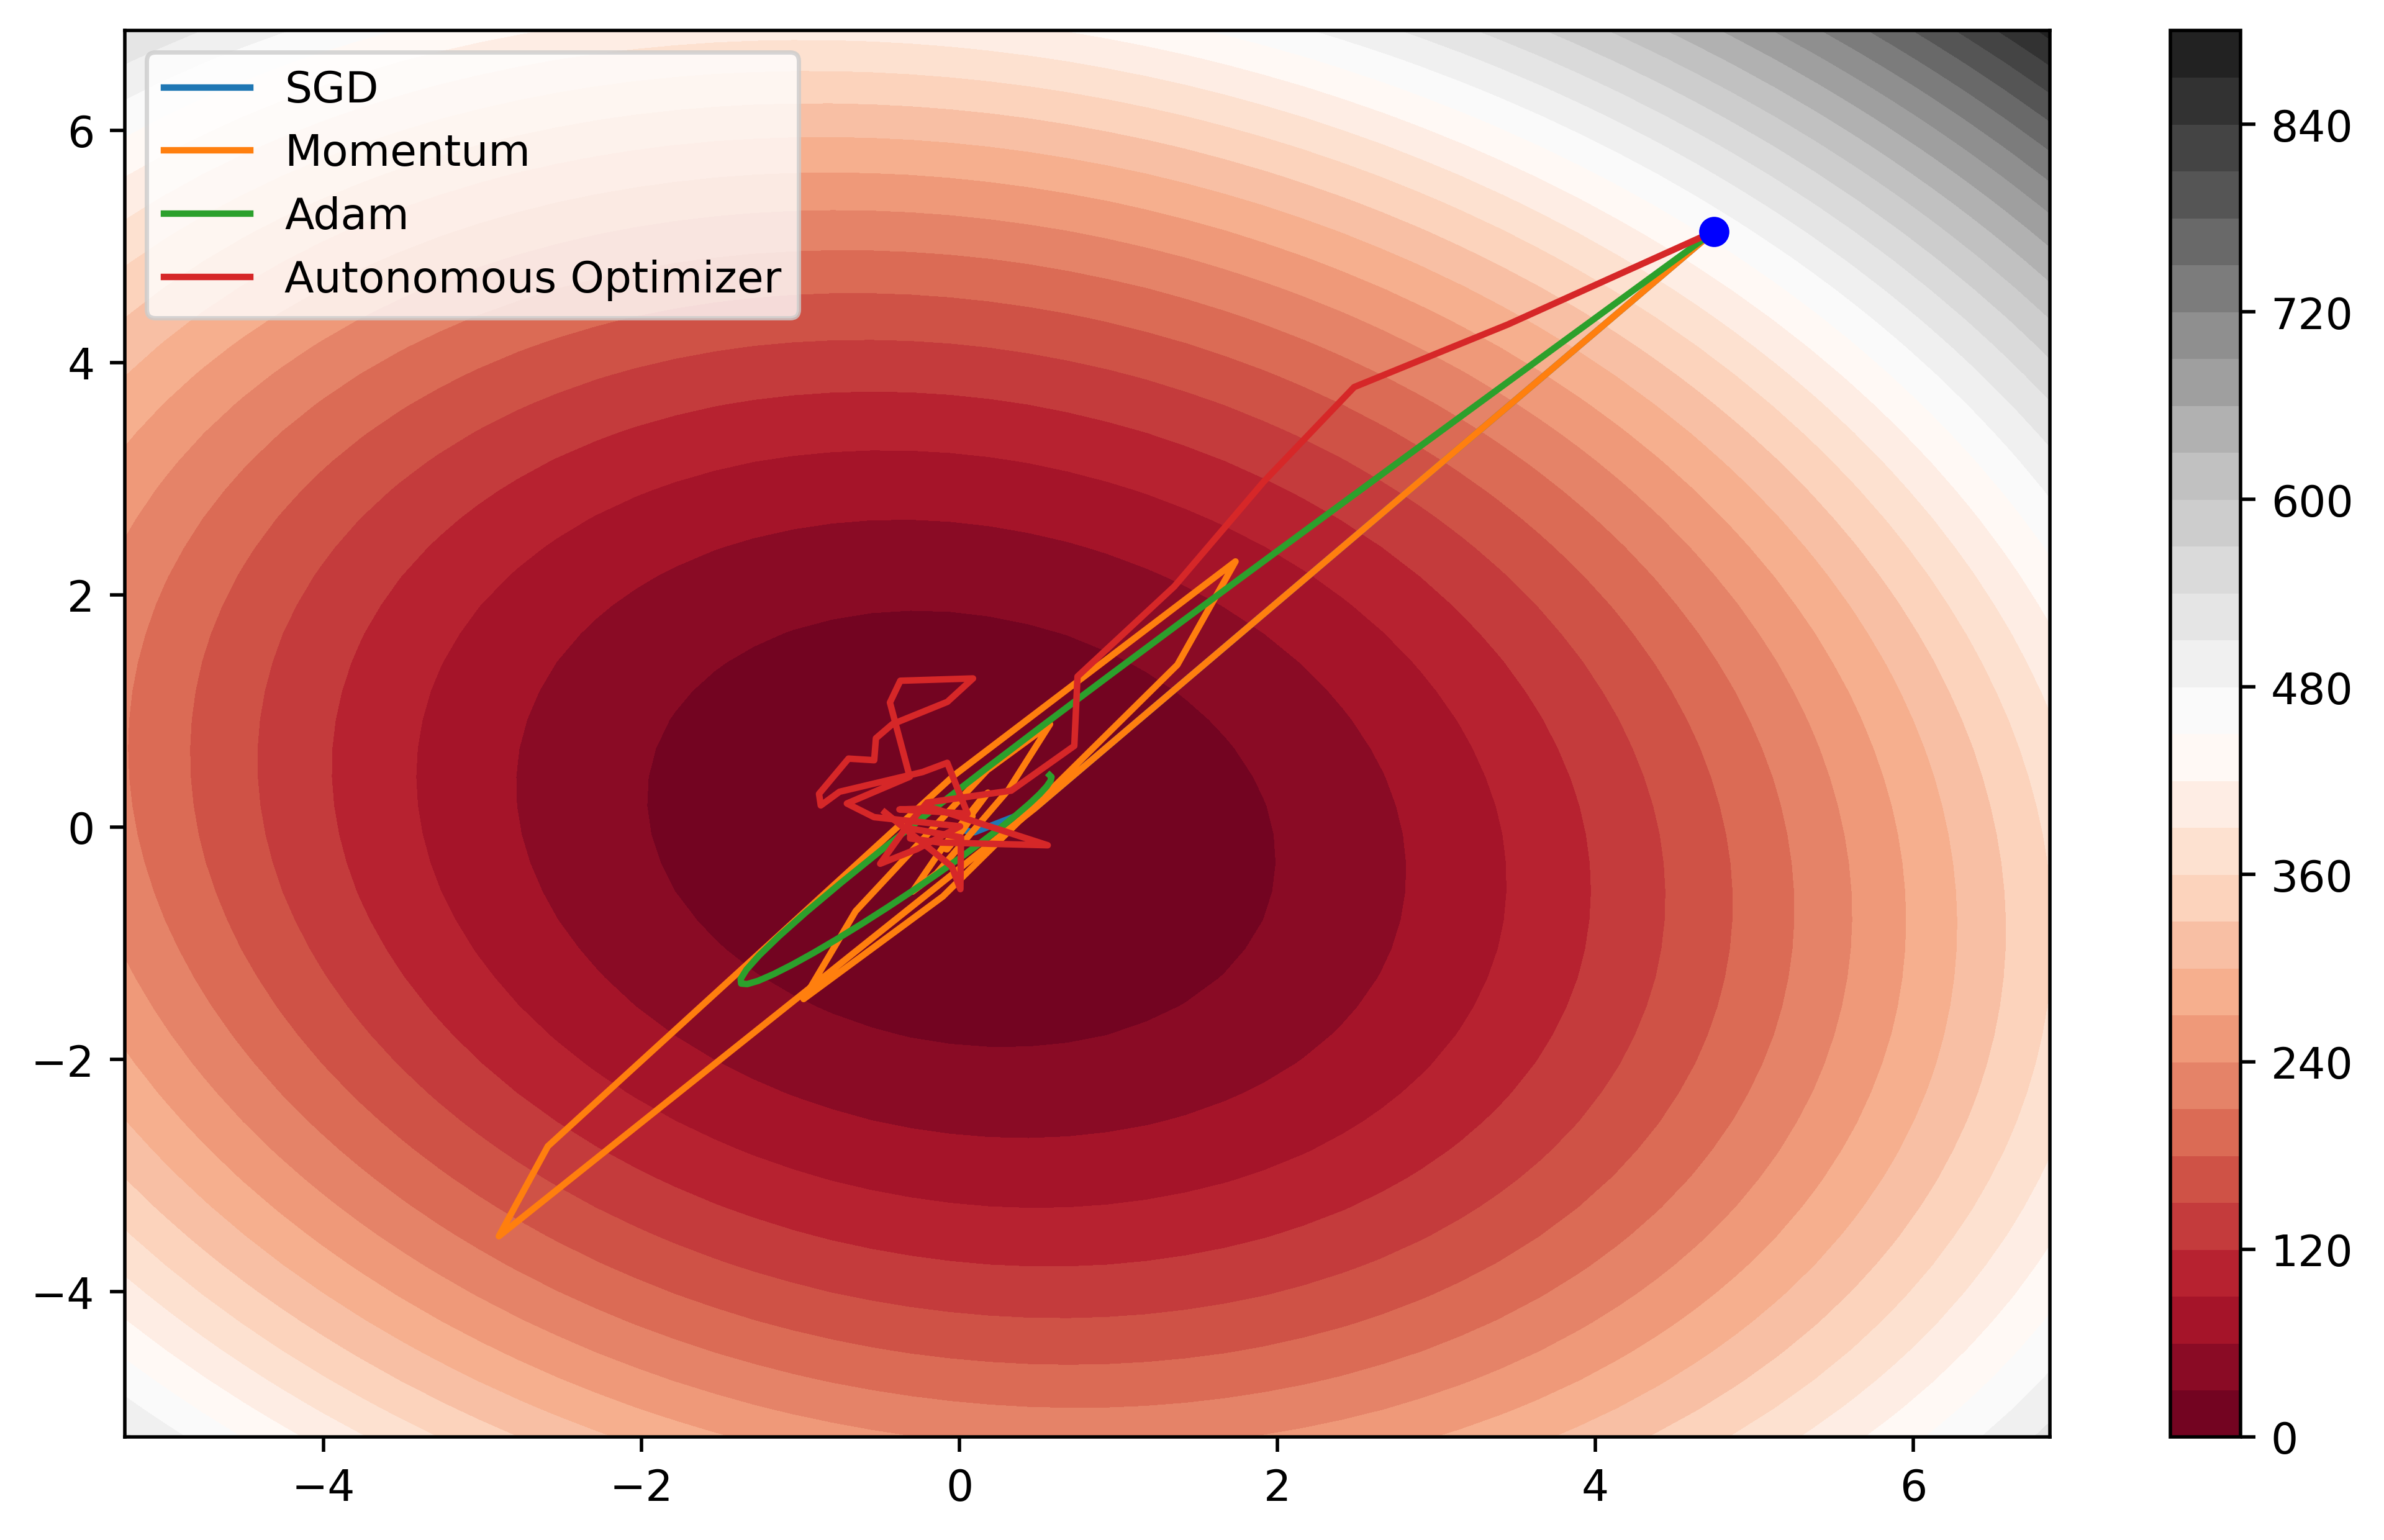

In [124]:
def get_weights(model):
    return model.x[0].item(), model.x[1].item()

def set_weights(model, w1, w2):
    model.x[0] = w1
    model.x[1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    get_weights, set_weights)

## Logistic Regression

In [121]:
lr_dataset = [benchmark.logistic_regression() for _ in range(90)]

def make_lr_env():
    return autonomous_optimizer.Environment(lr_dataset, num_steps=40, history_len=25)

In [122]:
lr_policy = stable_baselines.PPO2(
    stable_baselines.common.policies.MlpPolicy,
    stable_baselines.common.vec_env.DummyVecEnv([make_lr_env]*32),
    n_steps=2,
    verbose=0,
    tensorboard_log='tb_logs/lr'
)

In [123]:
lr_policy.learn(total_timesteps=200 * iterations * len(dataset))

In [198]:
lr_tune = {
    "sgd": {"hyperparams": {"lr": 5e-2}},
    "momentum": {"hyperparams": {"lr": 1e-1, "momentum": 0.7}},
    "adam": {"hyperparams": {"lr": 5e-1}}
}

In [199]:
problem = benchmark.logistic_regression()

model0 = problem["model0"]
obj_function = problem["obj_function"]

In [200]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, lr_tune, lr_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

SGD optimum: 0.2625749707221985
Momentum optimum: 0.10937172919511795
Adam optimum: 0.031040944159030914
LBFGS optimality gap: 0.027320321649312973


NameError: name 'lr_policy' is not defined

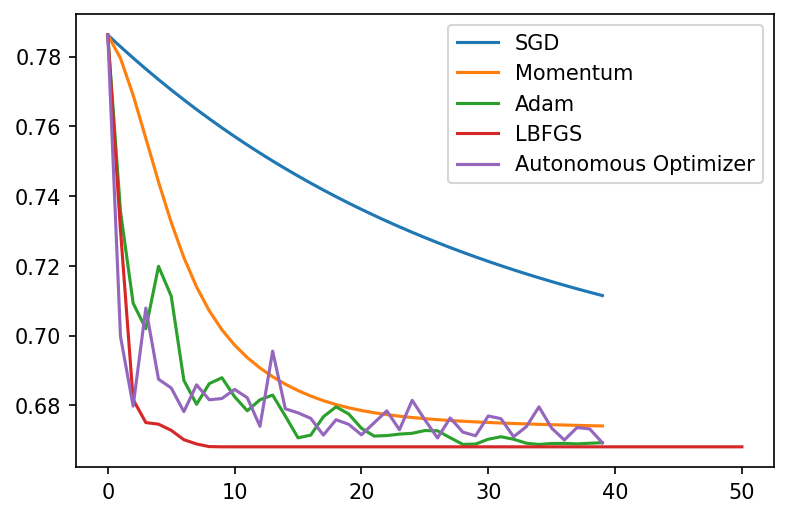

In [176]:
plt.figure(figsize=(6, 4), dpi=150)

plt.plot(sgd_vals, label='SGD')
plt.plot(momentum_vals, label='Momentum')
plt.plot(adam_vals, label='Adam')
plt.plot(lbfgs_vals, label='LBFGS')
plt.plot(ao_vals, label='Autonomous Optimizer')

plt.legend()
plt.show()

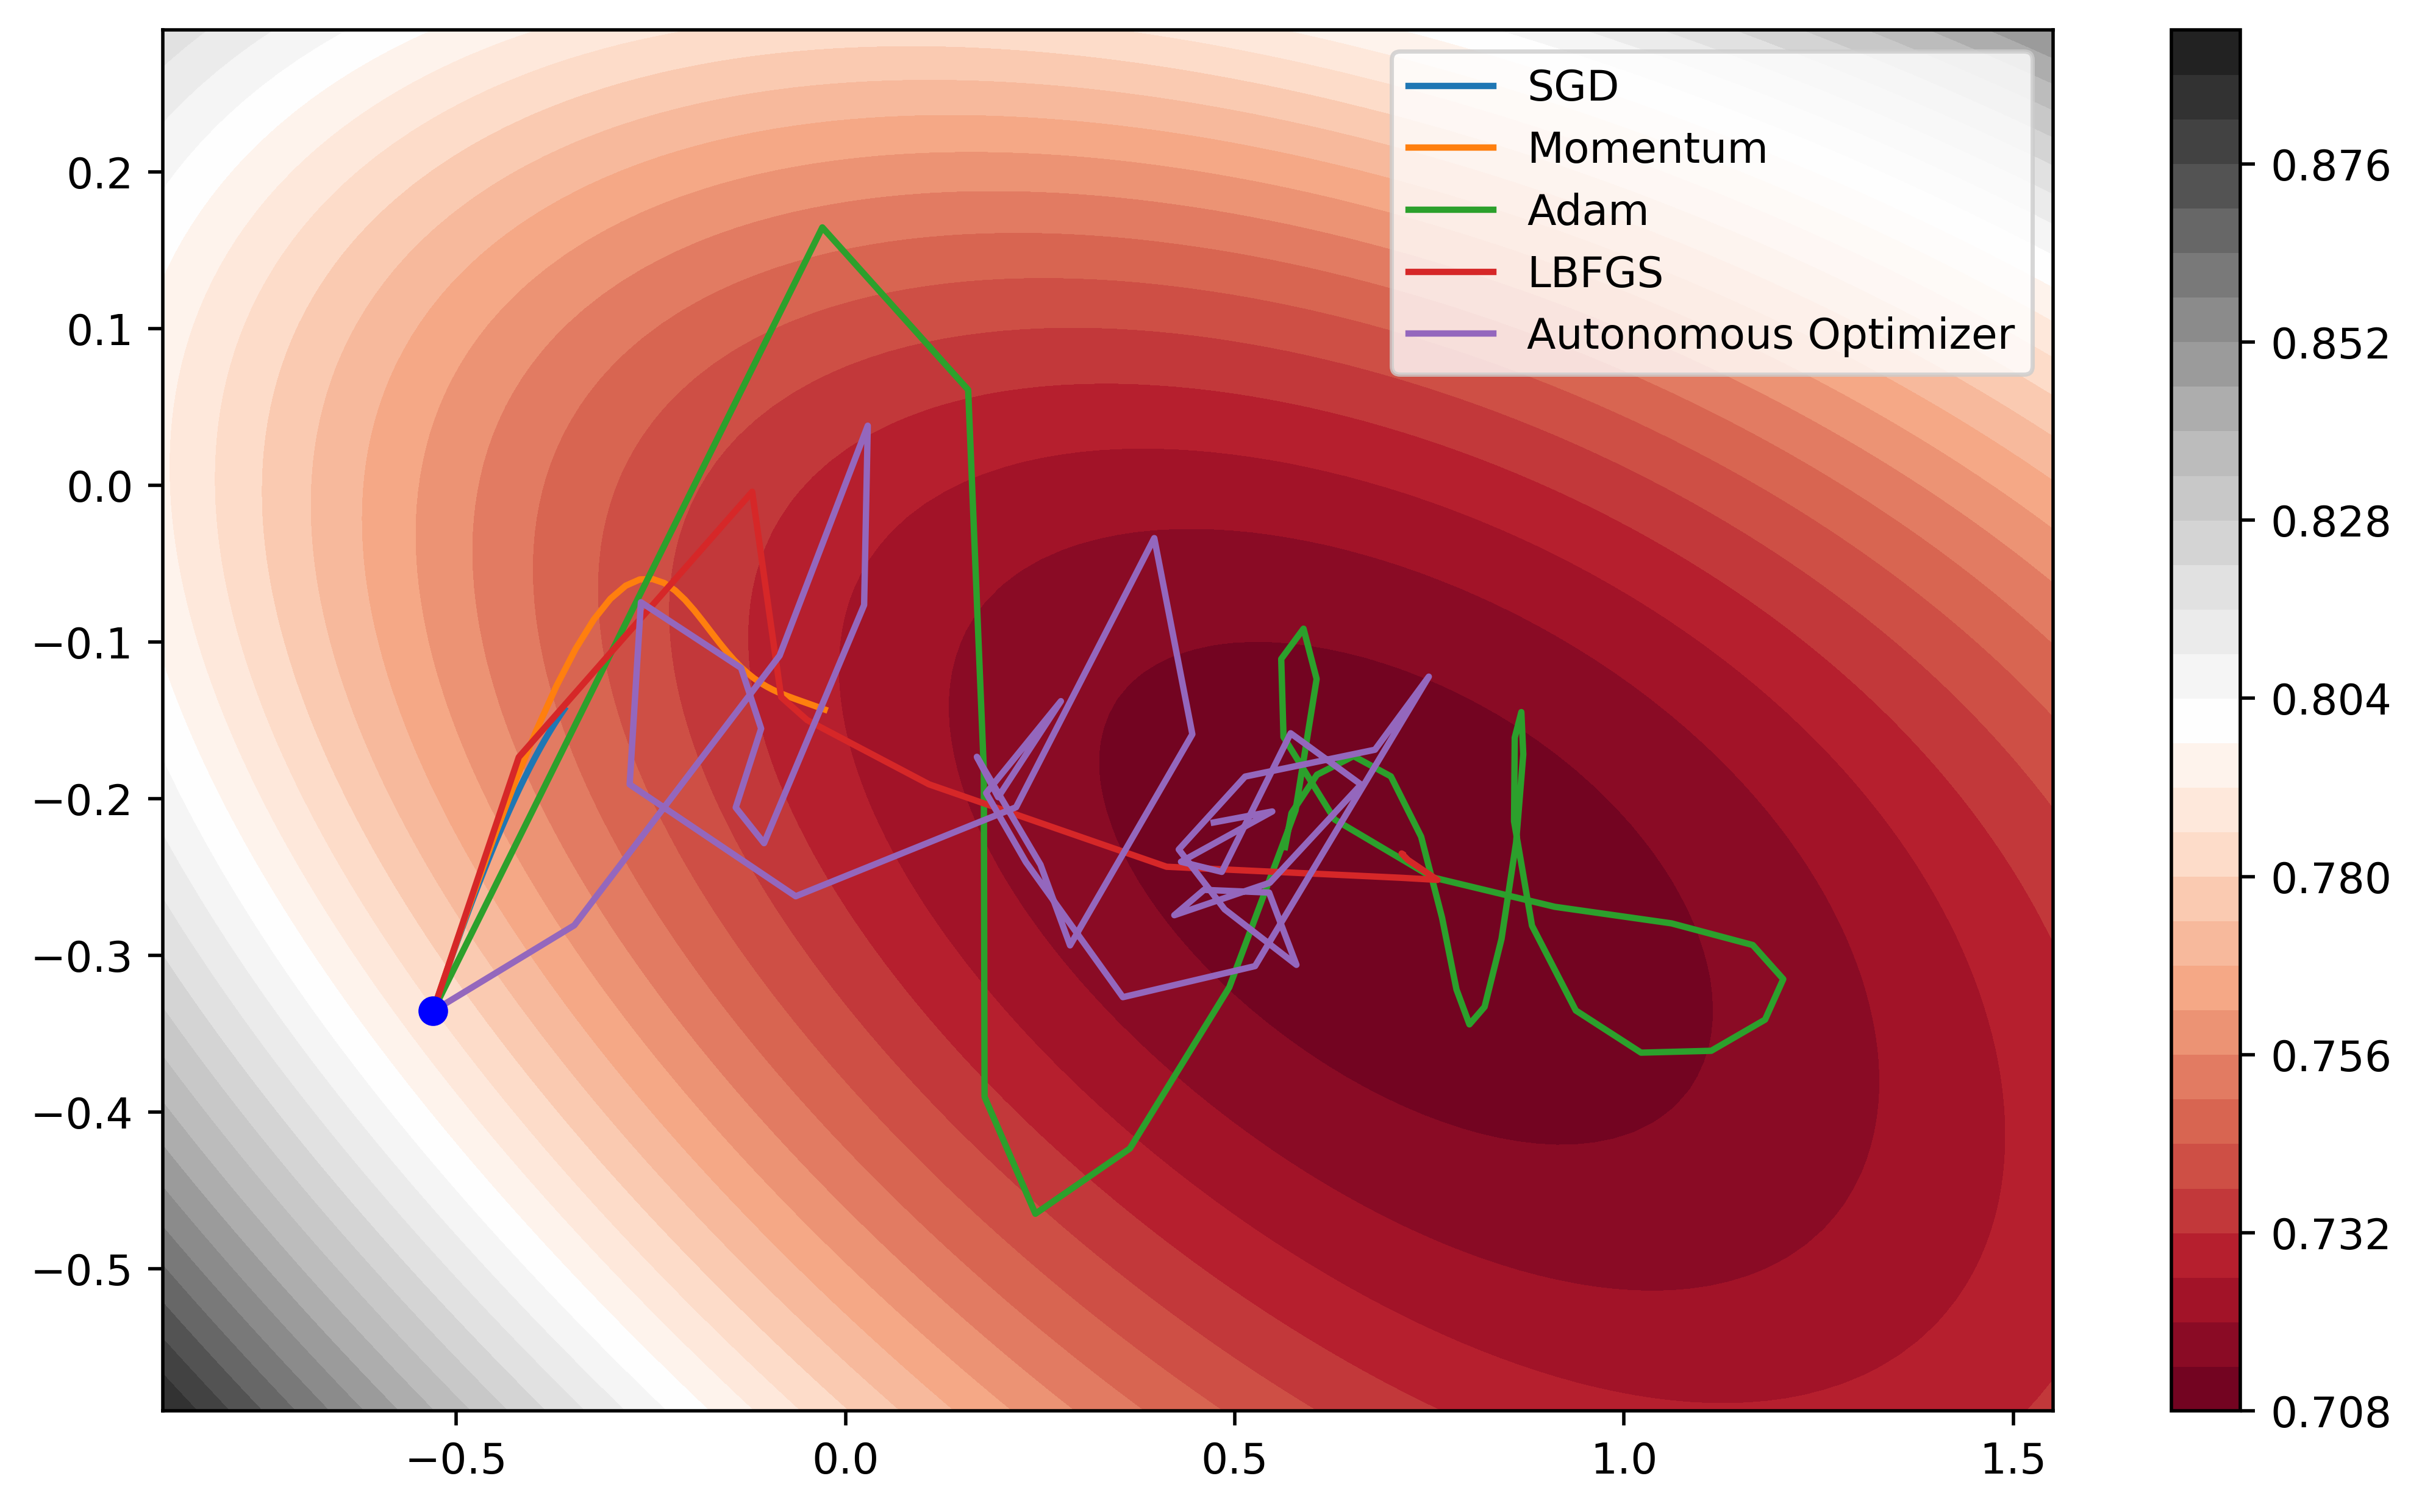

In [177]:
def get_weights(model):
    return model[0].weight[0, 0].item(), model[0].weight[0, 2].item()

def set_weights(model, w1, w2):
    model[0].weight[0, 0] = w1
    model[0].weight[0, 2] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    get_weights, set_weights)

## Robust Linear Regression

In [307]:
rlr_dataset = [benchmark.robust_linear_regression() for _ in range(120)]

In [308]:
rlr_env = stable_baselines.common.vec_env.DummyVecEnv([
    lambda: autonomous_optimizer.Environment(rlr_dataset, num_steps=40, history_len=25)
]*32)

rlr_policy = stable_baselines.PPO2(
    stable_baselines.common.policies.MlpPolicy,
    rlr_env,
    n_steps=4,
    verbose=0,
    tensorboard_log='tb_logs/rlr'
)

In [ ]:
rlr_policy.learn(total_timesteps=200 * rlr_env.envs[0].num_steps * len(rlr_dataset))

In [274]:
rlr_tune = {
    "sgd": {"hyperparams": {"lr": 5e-1}},
    "momentum": {"hyperparams": {"lr": 5e-1, "momentum": 0.9}},
    "adam": {"hyperparams": {"lr": 5e-1}},
    "lbfgs": {"hyperparams": {"lr": 0.1, "max_iter": 1}}
}

In [296]:
problem = benchmark.robust_linear_regression()

model0 = problem["model0"]
obj_function = problem["obj_function"]

In [297]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, rlr_tune, None)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

SGD best loss: 0.48892030119895935
Momentum best loss: 0.48932740092277527
Adam best loss: 0.48887157440185547
LBFGS best loss: 0.48892173171043396


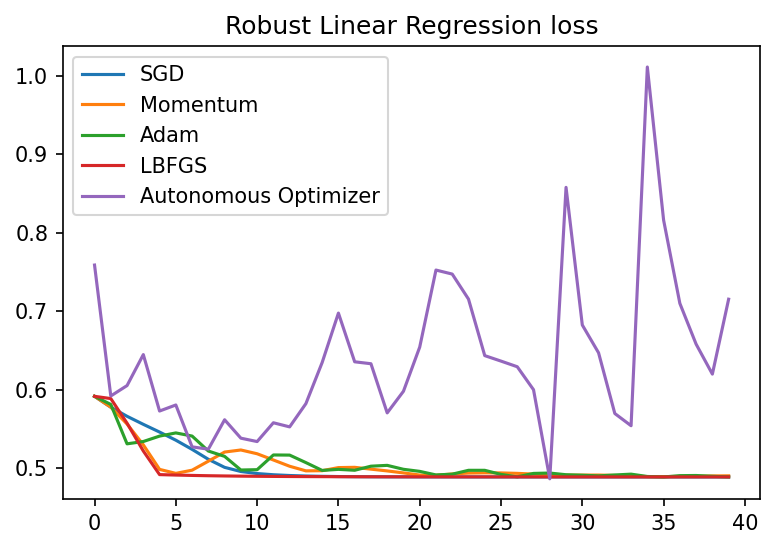

In [304]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('Robust Linear Regression loss')
plt.plot(sgd_vals, label='SGD')
plt.plot(momentum_vals, label='Momentum')
plt.plot(adam_vals, label='Adam')
plt.plot(lbfgs_vals, label='LBFGS')
plt.plot(ao_vals, label='Autonomous Optimizer')

plt.legend()
plt.show()

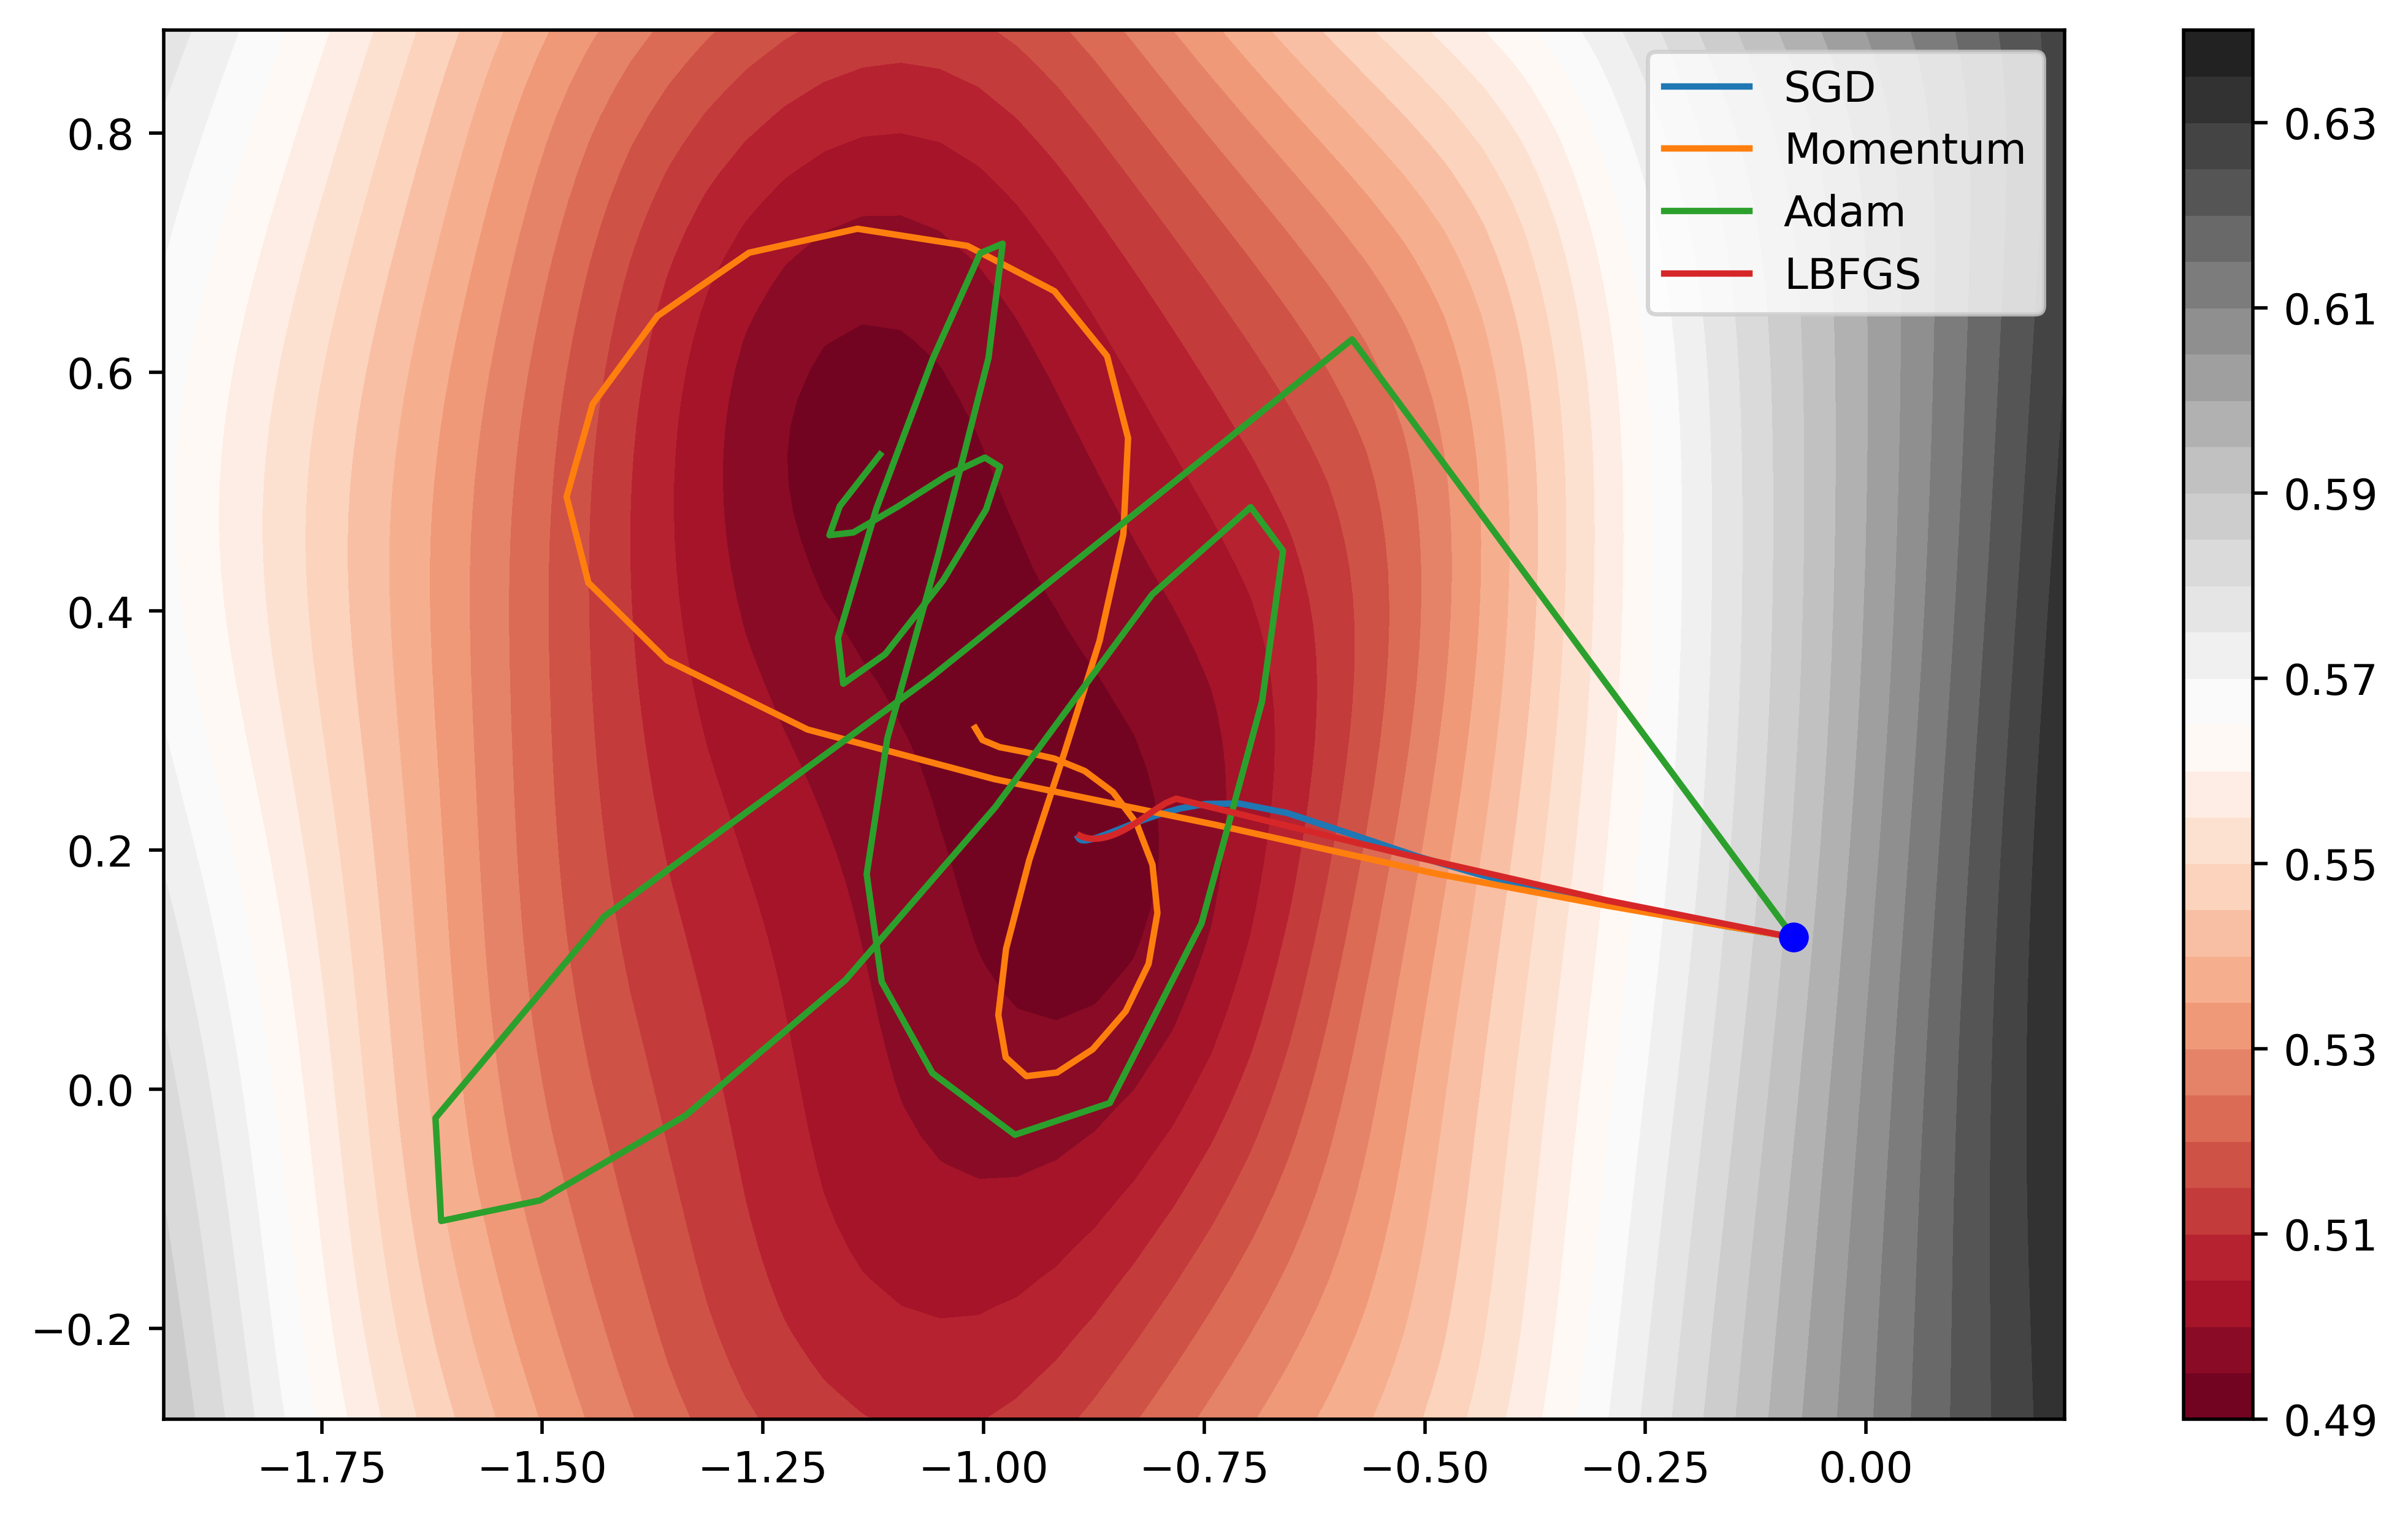

In [302]:
def get_weights(model):
    return model.weight[0, 0].item(), model.weight[0, 1].item()

def set_weights(model, w1, w2):
    model.weight[0, 0] = w1
    model.weight[0, 1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)

## Optimizing a 2-layer neural net

In [216]:
mlp_dataset = [benchmark.mlp() for _ in range(80)]

In [217]:
mlp_env = stable_baselines.common.vec_env.DummyVecEnv([
    lambda: autonomous_optimizer.Environment(mlp_dataset, num_steps=40, history_len=25)
]*32)

mlp_policy = stable_baselines.ACKTR(
    stable_baselines.common.policies.MlpPolicy,
    mlp_env,
    n_steps=4,
    verbose=0,
    tensorboard_log='tb_logs/mlp'
)

In [218]:
mlp_policy.learn(total_timesteps=200 * mlp_env.envs[0].num_steps * len(mlp_dataset))

In [219]:
mlp_tune = {
    "sgd": {"hyperparams": {"lr": 5e-1}},
    "momentum": {"hyperparams": {"lr": 5e-1, "momentum": 0.9}},
    "adam": {"hyperparams": {"lr": 5e-1}},
    "lbfgs": {"hyperparams": {"lr": 0.1, "max_iter": 1}}
}

In [220]:
problem = benchmark.mlp()

model0 = problem["model0"]
obj_function = problem["obj_function"]
x, y = problem["dataset"]

In [238]:
iterations = 40

def accuracy(model):
    return ((model(x).view(-1) > 0.5) == y).float().mean().item()

results = benchmark.run_all_optimizers(problem, iterations, mlp_tune, mlp_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

sgd_accuracy = np.array([accuracy(model) for model in sgd_traj])
momentum_accuracy = np.array([accuracy(model) for model in momentum_traj])
adam_accuracy = np.array([accuracy(model) for model in adam_traj])
lbfgs_accuracy = np.array([accuracy(model) for model in lbfgs_traj])
ao_accuracy = np.array([accuracy(model) for model in ao_traj])

print(f'\nSGD best accuracy: {sgd_accuracy.max()}')
print(f'Momentum best accuracy: {momentum_accuracy.max()}')
print(f'Adam best accuracy: {adam_accuracy.max()}')
print(f'LBFGS best accuracy: {lbfgs_accuracy.max()}')
print(f'Autonomous optimizer best accuracy: {ao_accuracy.max()}')

SGD best loss: 0.4752781391143799
Momentum best loss: 0.3310580551624298
Adam best loss: 0.31993088126182556
LBFGS best loss: 0.35298076272010803
Autonomous Optimizer best loss: 0.48651379346847534

SGD best accuracy: 0.75
Momentum best accuracy: 0.8799999952316284
Adam best accuracy: 0.8899999856948853
LBFGS best accuracy: 0.8700000047683716
Autonomous optimizer best accuracy: 0.7599999904632568


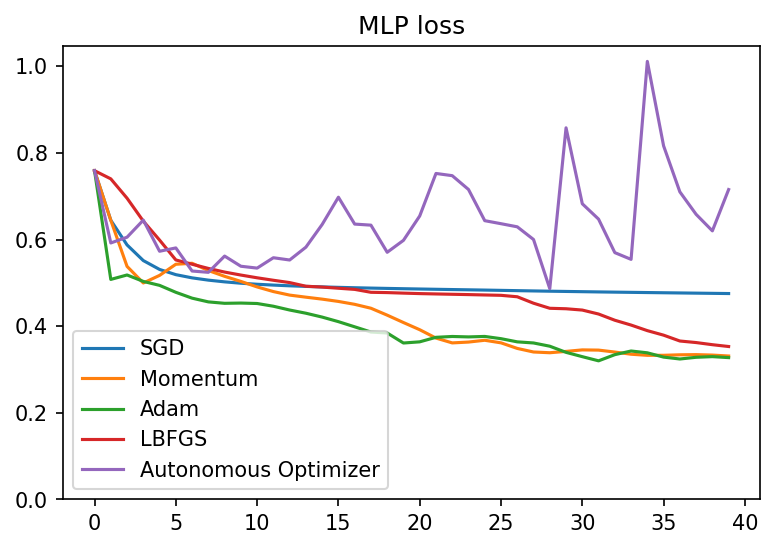

In [239]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('MLP loss')
plt.plot(sgd_vals, label='SGD')
plt.plot(momentum_vals, label='Momentum')
plt.plot(adam_vals, label='Adam')
plt.plot(lbfgs_vals, label='LBFGS')
plt.plot(ao_vals, label='Autonomous Optimizer')

if lbfgs_vals.max() > 1.5:
    plt.ylim(0, 1.5)
else:
    plt.ylim(0)

plt.legend()
plt.show()

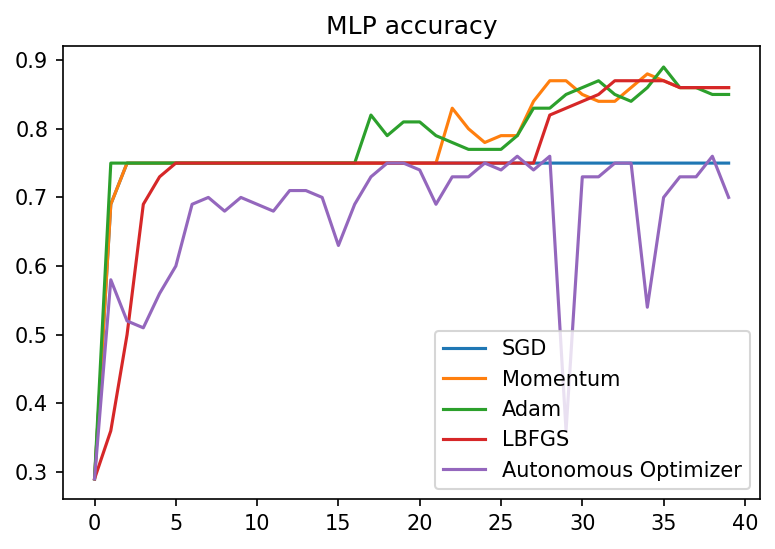

In [240]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('MLP accuracy')
plt.plot(sgd_accuracy, label='SGD')
plt.plot(momentum_accuracy, label='Momentum')
plt.plot(adam_accuracy, label='Adam')
plt.plot(lbfgs_accuracy, label='LBFGS')
plt.plot(ao_accuracy, label='Autonomous Optimizer')

plt.legend()
plt.show()

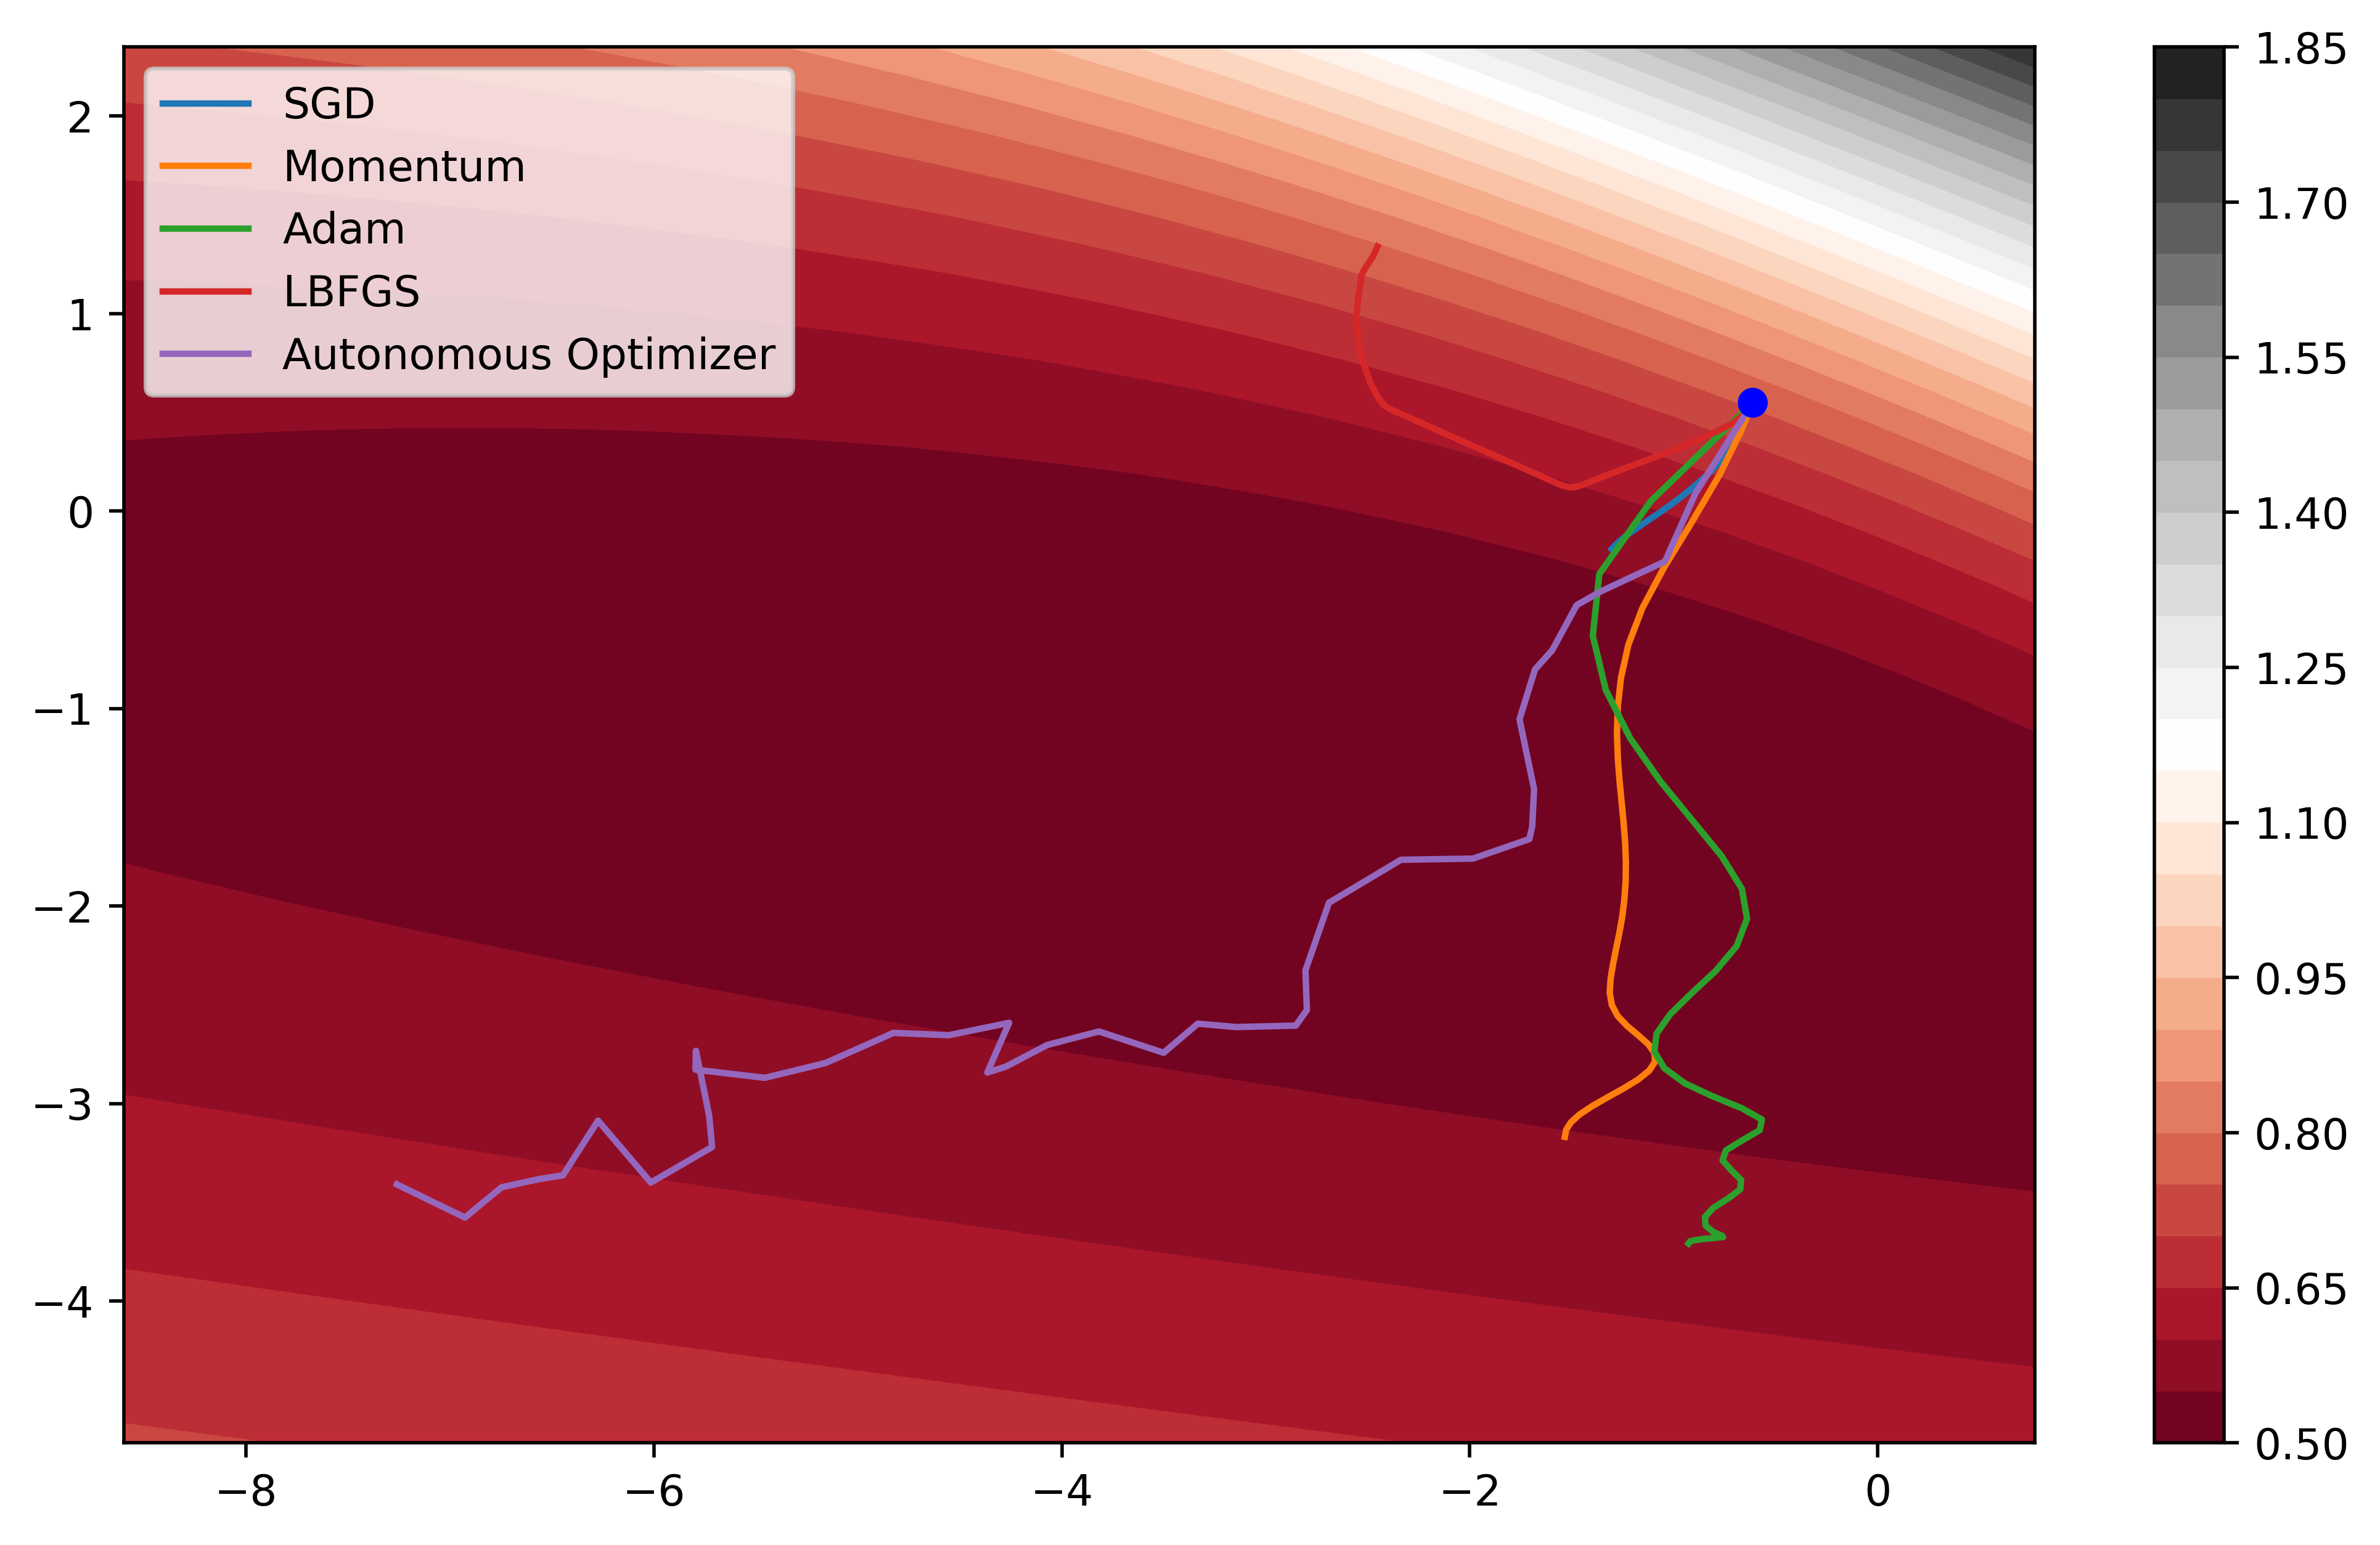

In [242]:
def get_weights(model):
    return model[2].weight[0, 0].item(), model[2].weight[0, 1].item()

def set_weights(model, w1, w2):
    model[2].weight[0, 0] = w1
    model[2].weight[0, 1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)